In [1]:
import sys
import torch  
import gym
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
import matplotlib.pyplot as plt

# REINFORCE

In [2]:
# Constants
GAMMA = 0.9

class PolicyNetwork(nn.Module):
    def __init__(self, num_inputs, num_actions, hidden_size, learning_rate=3e-4):
        super(PolicyNetwork, self).__init__()

        self.num_actions = num_actions
        self.linear1 = nn.Linear(num_inputs, hidden_size)
        self.linear2 = nn.Linear(hidden_size, num_actions)
        self.optimizer = optim.Adam(self.parameters(), lr=learning_rate)

    def forward(self, state):
        x = F.relu(self.linear1(state))
        x = F.softmax(self.linear2(x), dim=1)
        return x 
    
    def get_action(self, state):
        state = torch.from_numpy(state).float().unsqueeze(0)
        probs = self.forward(Variable(state))
        #Choose action with regard to policy
        highest_prob_action = np.random.choice(self.num_actions, p=np.squeeze(probs.detach().numpy()))
        log_prob = torch.log(probs.squeeze(0)[highest_prob_action]) #log for gradient
        return highest_prob_action, log_prob

In [3]:
def update_policy(policy_network, rewards, log_probs):
    discounted_rewards = []

    for t in range(len(rewards)):
        Gt = 0 
        pw = 0
        for r in rewards[t:]:
            Gt = Gt + GAMMA**pw * r
            pw = pw + 1
        discounted_rewards.append(Gt)
        
    discounted_rewards = torch.tensor(discounted_rewards)
    discounted_rewards = (discounted_rewards - discounted_rewards.mean()) / (discounted_rewards.std() + 1e-9) # normalize discounted rewards

    policy_gradient = []
    for log_prob, Gt in zip(log_probs, discounted_rewards):
        policy_gradient.append(-log_prob * Gt)
    
    policy_network.optimizer.zero_grad()
    policy_gradient = torch.stack(policy_gradient).sum()
    policy_gradient.backward()
    policy_network.optimizer.step()

In [4]:
#All available environments
#print(gym.envs.registry.all()) 

In [5]:
env = gym.make('CartPole-v0')
policy_net = PolicyNetwork(env.observation_space.shape[0], env.action_space.n, 128)
    
max_episode_num = 1000
max_steps = 10000
numsteps = []
avg_numsteps = []
all_rewards = []

for episode in range(max_episode_num):
    state = env.reset()
    log_probs = []
    rewards = []

    for steps in range(max_steps):
        env.render()
        action, log_prob = policy_net.get_action(state)
        new_state, reward, done, _ = env.step(action)
        log_probs.append(log_prob)
        rewards.append(reward)

        if done:
            update_policy(policy_net, rewards, log_probs)
            numsteps.append(steps)
            avg_numsteps.append(np.mean(numsteps[-10:]))
            all_rewards.append(np.sum(rewards))
            if episode % 10 == 0:
                sys.stdout.write("episode: {}, total reward: {}, average_reward: {}, length: {}\n".format(episode, np.round(np.sum(rewards), decimals = 3),  np.round(np.mean(all_rewards[-10:]), decimals = 3), steps))
            break
            
        state = new_state

episode: 0, total reward: 15.0, average_reward: 15.0, length: 14
episode: 10, total reward: 33.0, average_reward: 22.8, length: 32
episode: 20, total reward: 28.0, average_reward: 26.0, length: 27
episode: 30, total reward: 18.0, average_reward: 20.6, length: 17
episode: 40, total reward: 19.0, average_reward: 23.3, length: 18
episode: 50, total reward: 25.0, average_reward: 17.6, length: 24
episode: 60, total reward: 19.0, average_reward: 19.4, length: 18
episode: 70, total reward: 23.0, average_reward: 30.7, length: 22
episode: 80, total reward: 19.0, average_reward: 30.1, length: 18
episode: 90, total reward: 23.0, average_reward: 23.0, length: 22
episode: 100, total reward: 24.0, average_reward: 21.9, length: 23
episode: 110, total reward: 24.0, average_reward: 34.4, length: 23
episode: 120, total reward: 55.0, average_reward: 29.4, length: 54
episode: 130, total reward: 82.0, average_reward: 32.3, length: 81
episode: 140, total reward: 36.0, average_reward: 34.2, length: 35
episod

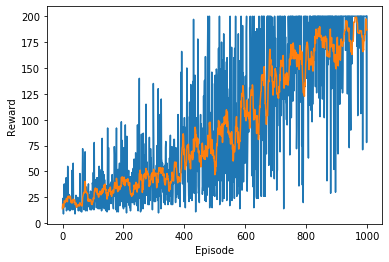

Varince of reward = 4765.980639


In [6]:
smoothed_rewards = pd.Series.rolling(pd.Series(all_rewards), 10).mean()
plt.plot(all_rewards)
plt.plot(avg_numsteps)
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.show()
print('Varince of reward = {}'.format(np.var(all_rewards)))